# Alice in Wonderland Hyperdictionary

I have created a hyperdictionary that contains each individual word in alice and wonderland. There are a few issues with the dictionary creation, as conjunctions aren't handled very well. This means several conjunctive words are present, such as 'll', 's', 't'. And then a few other spurious letters are stored in the dictionary as words.


In [1]:

import random_idx
import utils
import pickle
import re
import string

from pylab import *

%matplotlib inline


height has been deprecated.

2016-02-11 15:49


In [2]:
h = np.load('data/alice_word_hyperdictionary_d1M_160211.npz')
letter_vectors = h['letter_vectors']
hyperdictionary = h['hyperdictionary']

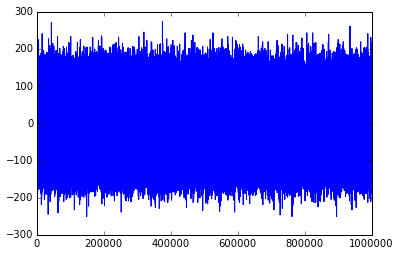

In [3]:
N = hyperdictionary.shape[0]
plot(hyperdictionary)

In [4]:
fdict = open("raw_texts/texts_english/alice_in_wonderland.txt")
text = fdict.read()

sentences = text.split('.')

In [5]:
len(sentences)

1207

In [6]:
def prepare_sentence(sentence_str):
    truth_text = sentence_str.lower()
    
    rm = string.punctuation + string.digits
    
    for i in string.punctuation:
        truth_text = truth_text.replace(i, '')
        
    truth_text = truth_text.replace('\n',' ')
    truth_text = truth_text.replace('\r','')
    truth_text = truth_text.replace('\t','')
    truth_text = truth_text.strip()
        
    trial_text = truth_text.replace(' ', '')
    
    return truth_text, trial_text

In [7]:
truth_text, trial_text = prepare_sentence(sentences[10])

In [8]:
trial_text # has no spaces

'firstshetriedtolookdownandmakeoutwhatshewascomingtobutitwastoodarktoseeanythingthenshelookedatthesidesofthewellandnoticedthattheywerefilledwithcupboardsandbookshelveshereandthereshesawmapsandpictureshunguponpegs'

In [9]:
truth_text # contains the spaces

'first she tried to look down and make out what she was coming to but it was too dark to see anything then she looked at the sides of the well and noticed that they were filled with cupboards and bookshelves here and there she saw maps and pictures hung upon pegs'

## The greedy way

The simplest thing to do is to go through the string of letters, and as soon as you find a word that they hyperdictionary recognizes then say that there should be a space.

In [10]:

def find_spaces_greedy(text):
    # going through the text letter by letter, and if you find a word, put a space.
    spaces = []
    
    subword = ''
    subvec = np.ones(N)
    for i,letter in enumerate(text):
        letter_idx = random_idx.alphabet.find(letter)
        subvec = np.roll(subvec, 1) * letter_vectors[letter_idx,:]
        subword += letter
        
        # check to see if the subvec is present in the hyperdictionary
        val = np.dot(subvec.T, hyperdictionary) / N
        
        if val > 0.5:
            # then we think that we just saw a whole word, and so we add spaces.
            spaces.append(i+1)
            # and start the subword and subvec over
            subword = ''
            subvec = np.ones(N)
    
    return spaces
            
def insert_spaces(spaces, trial_text):
    tt = trial_text
    for i,s in enumerate(spaces):
        tt = tt[:int(s+i)] + ' ' + tt[int(s+i):]
    return tt


In [11]:
spaces = find_spaces_greedy(trial_text)

print truth_text
print insert_spaces(spaces, trial_text)

first she tried to look down and make out what she was coming to but it was too dark to see anything then she looked at the sides of the well and noticed that they were filled with cupboards and bookshelves here and there she saw maps and pictures hung upon pegs
f i rstshetriedtolookdownandmakeoutwhatshewascomingtobutitwastoodarktoseeanythingthenshelookedatthesidesofthewellandnoticedthattheywerefilledwithcupboardsandbookshelveshereandthereshesawmapsandpictureshunguponpegs


So, in this case, 'f' and 'i' are indeed words in the book. Many of the single letters -- t, d, s, were put in the dictionary because of punctuation making it look like these were individual characters. So, the greedy algorithm doesn't do too great, because a lot of letters are considered words. 'rstshetried...' is not found so it gives up.

In [12]:
truth_text, trial_text = prepare_sentence(sentences[77])
spaces = find_spaces_greedy(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

perhaps it doesnt understand english thought alice i daresay its a french mouse come over with william the conqueror
perhaps i t d o e s ntunderstandenglishthoughtaliceidaresayitsafrenchmousecomeoverwithwilliamtheconqueror


## The lazy way

This way makes a bit more sense, we are going to search through from the start and find the longest word that is also present in the hyperdictionary. Then we will loop once we find the longest word space.


In [13]:
def find_spaces_from_start(text, max_look=float('inf')):
    # go through the whole text as if from the beginning and find all potential spaces.
    spaces = []
    val = np.zeros(min((max_look+1, len(text))))
    subword = ''
    subvec = np.ones(N)
    for i,letter in enumerate(text):
        letter_idx = random_idx.alphabet.find(letter)
        subvec = np.roll(subvec, 1) * letter_vectors[letter_idx,:]
        subword += letter
        
        # check to see if the subvec is present in the hyperdictionary
        val[i] = np.dot(subvec.T, hyperdictionary) / N
        
        if val[i] > 0.5:
            # then we think that we just saw a whole word, and so we add space to the next.
            spaces.append(i+1)
            
        if i >= max_look:
            break
    
    #print text
    #plot(val)
    return spaces
            
def find_spaces_lazy(text):
    spaces = []
    sp_last = 0
    
    while True:
        sp = find_spaces_from_start(text, 15)
        
        if len(sp) > 0:
            # then we found a space and will do the loop again, use longest word
            spaces.append(sp[-1]+sp_last)
            text = text[sp[-1]:]
            sp_last = sp_last + sp[-1]
        else:
            # Then we are done
            break
    return spaces
    

In [14]:
truth_text, trial_text = prepare_sentence(sentences[25])
spaces = find_spaces_lazy(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

but do cats eat bats i wonder and here alice began to get rather sleepy and went on saying to herself in a dreamy sort of way do cats eat bats do cats eat bats and sometimes do bats eat cats for you see as she couldnt answer either question it didnt much matter which way she put it
but do cats eat bats i wonder and here alice began to get rather sleepy and went on saying to herself in a dreamy sort of way do cats eat bats do cats eat bats and sometimes do bats eat cats for you see as she couldn t answer either question it didn tm u c hm at t e rwhichwaysheputit


so, in this case it messed up at the end.


In [15]:
truth_text, trial_text = prepare_sentence(sentences[77])
spaces = find_spaces_lazy(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

perhaps it doesnt understand english thought alice i daresay its a french mouse come over with william the conqueror
perhaps it doesn t understand english thought alice i daresay its a french mouse come over with william the conqueror 


In [16]:
truth_text, trial_text = prepare_sentence(sentences[100])
spaces = find_spaces_lazy(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

ahem said the mouse with an important air are you all ready this is the driest thing i know
ahem said them ou s e with an important air are you all ready this is the driest thing i know 


## Using recursion

We can make a recursive function that will search through the possibilities and only spit out answers if every word is found.

In [17]:

def find_spaces_recursive(text):
    spaces = np.array([])
    
    sp = find_spaces_from_start(text, 15)
       
    iswhole = False
    
    if len(sp) > 0:
        # then we found a space and will do the loop again
        sp_r = []
        nspaces = []
        
        # go through long to short
        for sidx in sp[::-1]:
            ss, iswhole = find_spaces_recursive(text[sidx:])                                
            nspaces.append(len(ss))
            sp_r.append(ss)
            
            if iswhole:
                # Then we are at the end and the whole thing was good!.                
                if len(ss) == 0:
                    spaces = np.hstack((spaces, sidx)) 
                else:
                    spaces = np.hstack((spaces, sidx, ss+sidx))
                    
                break
        
        if not iswhole:
            # So, going to return the recursive call that had the most spaces
            mxidx = np.argmax(nspaces)
            sp_fixed = sp_r[mxidx] + sp[mxidx]
            spaces = np.hstack((spaces, sp_fixed))
            
    if len(text) == 0:
        iswhole = True
        spaces = np.array([])
    
    elif not iswhole:
        if len(sp) > 0 and sp[-1] == len(text):
            # then the whole word was found
            iswhole = True
        
    return spaces, iswhole

In [18]:
truth_text, trial_text = prepare_sentence(sentences[502])
spaces, iswhole = find_spaces_recursive(trial_text)

In [19]:
print truth_text
print insert_spaces(spaces, trial_text)

he moved on as he spoke and the dormouse followed him the march hare moved into the dormouses place and alice rather unwillingly took the place of the march hare
he moved on as he spoke and the dormouse followed him them arch hare moved into the dormouse s place and alice rather unwillingly took the place of them arch hare 


In [20]:
truth_text, trial_text = prepare_sentence(sentences[302])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

and certainly there was a most extraordinary noise going on withina constant howling and sneezing and every now and then a great crash as if a dish or kettle had been broken to pieces
and certainly there was am o s t extraordinary noise going on within a constant howling and sneezing and every now and then a great crash as if a dish or kettle had been broken top i e c e s 


In [21]:
truth_text, trial_text = prepare_sentence(sentences[662])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

alice did not quite like the look of the creature but on the whole she thought it would be quite as safe to stay with it as to go after that savage queen so she waited
alice didn o t quite like the look of the creature but on the whole she thought it would be quite as safe to stay with it as to go after that savage queens o she waited 


In [22]:
truth_text, trial_text = prepare_sentence(sentences[882])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

ive so often read in the newspapers at the end of trials there was some attempts at applause which was immediately suppressed by the officers of the court and i never understood what it meant till now
iv e soo f ten read in then e w s paper sat the end of trials there was some attempts at applause which was immediately suppressed by the officers of the court and in ever understood what it meant till now 


In [23]:
truth_text, trial_text = prepare_sentence(sentences[910])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

alice looked at the jurybox and saw that in her haste she had put the lizard in head downwards and the poor little thing was waving its tail about in a melancholy way being quite unable to move
alice looked at the jury box and saw that in her haste she had put the lizard in head downwards and the poor little thing was waving its tail about in a melancholy way being quite unable to move 


In [24]:
truth_text, trial_text = prepare_sentence(sentences[12])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

well thought alice to herself after such a fall as this i shall think nothing of tumbling down stairs how brave theyll all think me at home why i wouldnt say anything about it even if i fell off the top of the house which was very likely true
well thought alice to herself after such a fall as this is hall think nothing of tumbling down stairs how brave they ll all think meat home why i wouldn t say anything about it even if if e ll off the top of the house which was very likely true 


In [25]:
truth_text, trial_text = prepare_sentence(sentences[13])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

down down down
down down down 


In [26]:
truth_text, trial_text = prepare_sentence(sentences[14])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

would the fall never come to an end i wonder how many miles ive fallen by this time she said aloud
would the fall never come to an end i wonder how many miles iv e fallen by this times he said aloud 


In [27]:
truth_text, trial_text = prepare_sentence(sentences[305])
spaces, iswhole = find_spaces_recursive(trial_text)
print truth_text
print insert_spaces(spaces, trial_text)

he was looking up into the sky all the time he was speaking and this alice thought decidedly uncivil
he was looking up into the sky all the time he was speaking and this alice thought decidedly uncivil 
